## Modeling Insights notebook
This is the Modeling insights notebook for the Solar Forecasting Intensity project
By: <br>
Andres Aguilar  <br>
Martijn de Vries<br>
William Lopez<br>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
#set a global random seed
np.random.seed(44)

## Baseline Model

To evaluate the success of our models, we establish the baseline model here, which we define as the GHI produced on an average day in the 5 year dataset

First, we load in the data

In [3]:
df = pd.read_csv('../data/NSRDB_to_model.csv')
df.head()

,datetime,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
0,2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
1,2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2,2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
3,2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
4,2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


Now we need to calculate the GHI curve of an average day. We can do this by folding the series every 48 timesteps (=1 day)

In [6]:
def calc_average_GHIcurve(ghi, ts=48):
    """
    Given a series of GHI values and the number of observations in a single day
    calculate the average daily GHI curve 
    Returns:
        average curve, with the same length as the input dataset
    """
    glen = len(ghi)
    ndays = glen//ts
    ghi_arr = np.zeros((ts, ndays))
    for i in range(ndays):
        ghi_arr[:,i] = ghi[i*ts:(i+1)*ts]
    return np.array(list(np.mean(ghi_arr, axis=1))* ndays)

In [7]:
avg_ghi = calc_average_GHIcurve(df['GHI'])

Let's plot the average curve

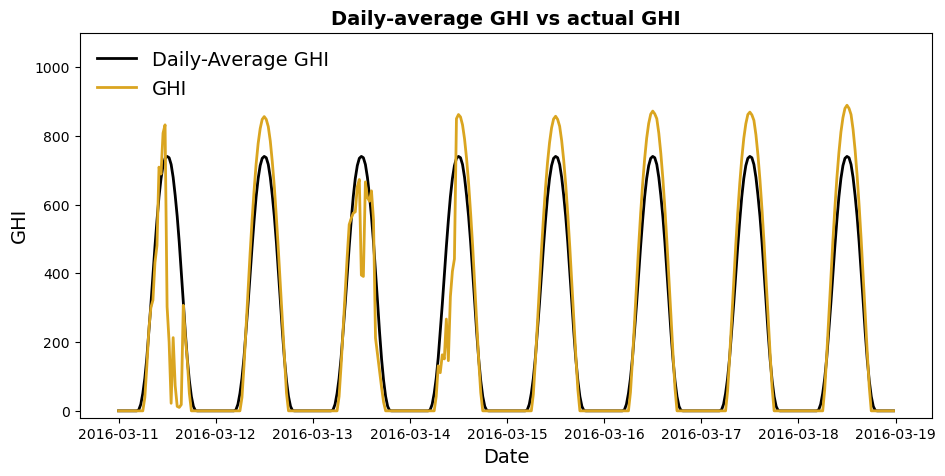

In [36]:
ndays = 8
i = 70
#time = list(np.arange(0, 24, 0.5))*ndays
fig, ax = plt.subplots(figsize=(11, 5))
dates = pd.to_datetime(df['datetime'])[i*48:48*(ndays+i)]
ax.plot(dates, avg_ghi[i*48:48*(ndays+i)], label='Daily-Average GHI', color='black', linewidth=2)
ax.plot(dates, df['GHI'][i*48:48*(ndays+i)], label='GHI', color='goldenrod', linewidth=2)

ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('GHI', fontsize=14)
ax.legend(frameon=False, fontsize=14)
ax.set_ylim(-20, 1100)
ax.set_title('Daily-average GHI vs actual GHI', fontsize=14, fontweight='bold');

Now we can establish the root mean squared error and mean absolute error for the baseline model.

First, we'll need to again filter out points where the solar zenith angle is above 90 degrees

In [41]:
idx = np.where(df['Solar Zenith Angle'] < 90)
ghi_filt = df['GHI'].iloc[idx]
avg_ghi_filt = avg_ghi[idx]

In [42]:
rmse_base = mean_squared_error(ghi_filt, avg_ghi_filt, squared=False)
mae_base = mean_absolute_error(ghi_filt, avg_ghi_filt)

print(f'The Root mean squared error for the baseline model is {round(rmse_base,2)} W/m2')
print(f'The mean absolute error for the baseline model is {round(mae_base,2)} W/m2')

The Root mean squared error for the baseline model is 198.4 GHI
The mean absolute error for the baseline model is 160.68 GHI


## Model comparison

In this project, we used 3 different models: a Neural Prophet model, an Recurrent Neural Network, and a WaveNet Neural Network. 

### 1) Neural Prophet Model

Some of the advantages of using a Neural Prophet Model is the interpretability, the automation, and its flexibility since it can be used for various time series patterns including trend, seasonality, and holiday effects depending on your data. On the other hand, the neural prophet model does require data to be in a very specific format, it works best on one-time series meaning it can only observe one variable at a time, and it also lacks additonal feature usage. The neural prophet performs relatively well, the downside is that it requires the predictor value to already be part of the data so in some situations there might be additional modelling required before being ablel to use the model. It is possible for an energy company to use the application of this model to predict single variables using just the date-time information gathered.

In terms of performance, the neural prophet model returned and RMSE of 122.7 and an MAE of 89.9, meaning the model is performing 38% better in terms of RMSE and 44% better in terms of MAE before filtering the Solar Zenith Angle. Once we filtered the Solar Zenith Angle the model returned 120.48 RMSE and 87.82 MAE which means that in terms of RMSE the model is performing 45% better, and 45% better in terms of MAE. The neural prophet model does lack a built-in stopping mechanism for training and it lacks additional feature usage. Additionally the model runs plotly under the hood and there is a current bug that says the current version of plotly and neural prophet are not compatible. The solution found was to comment out the plotly resampler line in the parameters of the plotly code.  Additionally, you need to have your y-variable included in the data so that means that additional processing and modeling is required on the side if this is missing data, in our case we were predicting GHI and it was already included in our dataset.  It would be interesting to see how features affect the model rather than just using the predictor variable and the datetime.

### 2) Recurrent Neural Network

The advantages of an RNN (and similar neural-net based setups) are that we can easily use a host of different features to forecast the GHI into the future. From the perspective of a power company that wants to forecast the amount of solar power that can be generated for the next day, this could be advantageous as the GHI can be forecasted without knowledge of the current GHI. Only relatively more-easy-to-measure weather data is needed.

In terms of performance, we find that the RNN model with polynomial feature epansion performs slightly better than the model with simple features. The polynomial features model has RMSE scores of 106.5 and 119.9 W/m2 on the train and test data, respectively. This means that this model does about 39% better than the baseline model. The MAE scores are 72.1 and 78.0 W/m2 on the train and test data, which means that the model does about 49% better than the baseline model. The recurrent neural network is also relatively quick to train, which would make it easier to apply this model and use it to forecast the weather in other locations with relatively little computing power.

### 3) WaveNet Neural network

The main advantage of the WaveNet model is that it can be used with larger time sequences through the use of dilated convolutional layers. It has shown great success in one dimensional data in the form of audio signal, but attempting to modifying for the use of prediction through a larger number of features had its challenges.

- For one the increasing of features from 1 to 19, without the inclusion of the target variable, increased the training time of the large model significantly. 
- The change in feature dimension also saw an ambiguity between the continued use of 1D convolutional layers or switching to 2D layers, we had decided on sticking to 1D convolutions. 

From the results of our model, we found that it had made improvements on the baseline model. The errors for the WaveNet model were 
- RSME: 91.4 and 135.0 on training and test sets, respectively. 
- MAE: 59.6 and 81.5 on train and test sets, respectively. 
While the errors improved from the baseline model by about 32% for RSME and 50% for MAE, we can see that the model is overfitting on the training set. This was attempted to be minimized through the used of *l2* regularization in the dilated convolutional layers, but is still significant.

### Model scores (after filtering for Solar Zenith Angle)
|Model|Training RMSE|Testing RMSE|Training MAE|Testing MAE|
|---|---|---|---|---|
|Baseline | N/A  | 198.4 | N/A | 160.7 |
|Neural Prophet|120.48|101.96|87.82|59.25 |
|RNN| 106.5 | 119.9 | 72.1 | 78.0 |
|WaveNet| 91.4 | 135.0 | 59.6 | 81.54 |


## Conclusions and recommendations

In the upscaling and increased implementation of renewable energies, and specifically solar power, we found that one challenge where data science can be applied is forecasting of energy output. For solar power, this would be through the predictions of global horizontal irradiance, or GHI.  

From our analysis and model building, we found that our best predicting model, with smallest RMSE and MAE, was our Neural Prophet model. This is the model that we would recommend to be used for local and national solar power plants and companies, as well as other non-renewable energy companies, to use in predicting solar power output, with the caveat that it would require them to have their own model for the GHI, given that the prophet model is based on forecasting the GHI with previous, lagged GHI values. Unfortunately, the data from the NSRDB is not current, and so using these data would not be possible for up-to-date forecasting. 

If only meteorological data is available, we recommend the use of our RNN model. This model, of the two models using meteorological data, performed the most reliably with smaller erros compared to the WaveNet model. 

In all three models, we find that forecasting shorter-timescale events (like the sudden appearance of clouds) can be difficult, and it appears to be an important reason for why the model can sometimes make predictions that are very wrong. Further improvements could likely be made in this area. One way potential way to improve the models would be to forecast the solar irradiance not as a single value but as a range of values, within some probability interval. ughts here on time series, and why it will always be intrinsically uncertain. Our models show that eg. forecasting clouds is pretty difficult, especailly a day in advance.